# This notebook evaluates the results of the different model experiments and generates the OAA leaderboard

The goal of this notebook is to compare different models trained on the tbj2021 questionnaire groundball dataset, ultimately select one, and use it's probability predictions to evaluate Outs Above Average for the set of shortstops in the dataset. Since accurate probabilities are the key to the OAA metric, not only will I look at the log-loss for these models, but also the calibration of their probability output. A good probability calibration curve (y=x), minimal pathelogical behaviour from probability estimates (not missing values near 0 or near 1), and a comparatively good Brier score will determine which model I pick. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics 
    # metrics.brier_score_loss
    # metrics.log_loss
    # metrics.accuracy


# custom code found in this package
from ss_defense_experiment_main_preamble import experiment_prep
from utils.ml_training import ModelPersistance
from utils.viz_utils import Diamond, plot_single_sample
from utils.evaluation import train_model, summarize_model

Note that model experiments have already been run, so the decisions for feature design, set-up of models and choice of hyperparameters are not covered in this notebook. To see this part of the project, look at the `src/ss_defense_experiments_*.py` files for entrypoints (config) for model experiments. The `src/utils/` directory has the code for running a model experiment and saving it to the model registry.

### Table of Contents:

1. Grab results and summarize by model
2. Load the best model for each family, and plot their probability calibration info
3. Compare best two models in more detail
4. Generate OAA leaderboard


## 1 - Grab results and summarize by model

The results of model training were saved in the `data/models/model_registry.jsonl` file, along with the config for each of the models trained.  This code block ingests this data to compare models.

In [2]:
results = ModelPersistance.retrieve_registry_records(sorted_by='objective_value')

In [3]:
grouped = results.groupby('experiment_name')
grouped = grouped.agg({'id':'count', 'objective_value':[np.mean, np.std, np.min]}).sort_values(('objective_value',  'amin'), ascending=True).rename(columns={'objective_value':'log-loss'})
grouped

id  log-loss            \
                                                count      mean       std   
experiment_name                                                             
Random Forest                                      20  0.255637  0.036753   
SVM-RBF v1                                         20  0.271277  0.026757   
Gaussian Process                                    1  0.263653       NaN   
Gradient Boosted Trees                              1  0.270949       NaN   
SVM-Poly v1                                        15  0.349089  0.075535   
Multilevel Logistic Regression v1                   1  0.302501       NaN   
Logistic Regression                                20  0.308613  0.009266   
GAM v1                                              1  0.316038       NaN   
Logistic Regression No Preprocessing (Baseline)    20  0.566157  0.000433   

                                                           
                                                     amin  
experiment_name                                            
Random Forest                                    0.244740  
SVM-RBF v1                                       0.258142  
Gaussian Process                                 0.263653  
Gradient Boosted Trees                           0.270949  
SVM-Poly v1                                      0.285957  
Multilevel Logistic Regression v1                0.302501  
Logistic Regression                              0.305087  
GAM v1                                           0.316038  
Logistic Regression No Preprocessing (Baseline)  0.565985

The log-loss 'amin' column is the lowest log-loss for any model in that experiment. You can see that some experiments tried 15 or 20 different models (different hyperparameter settings), while others only trained one model. Some reasons only one model was trained for some experiments:
- Multilevel Logistic Regression v1 has no hyperparameters, and it is inappropriate to iteratively change priors to train a new model on the same data.
- Gaussian Process models automatically tune their hyperparameters in the sklearn libray.
- Gradient Boosted Trees used XGBoost which didn't play well with the Bayesian Optimization library I was using.
- GAMv1 was a particular combination of specific basis functions, and while there was definitely room to modify those basis functions, I ran out of time.

Notable from this table are the following observations:
- The 'dummy' baseline model performed much worse than the other models. The only difference between `Logistic Regression No Preprocessing (Baseline)` and `Logistic Regression` was preprocessing to the input matrix, so it's clear that this feature design had a big impact on the success of the models. 
- Random Forest had a model that had the best log-loss of all the model families in the group, with rbf-SVM 2nd, and Gaussian Process 3rd. That being said it doesn't look like there was that much difference between the different model families, so the choice of which model to select will most likely come down to just the probability calibration evaluation.
- There is evidence that the model families leading in log-loss overfit, at least compared to the `Logistic Regression` model family. The std of log-loss between models in a given family show that there is higher variance and thus more overfitting for those model families.

## 2 - Load the best model for each family, and plot their probability calibration info

In [4]:
all_models = {}

In [5]:
%%time

for experiment_name in grouped.index:
    model_id = results[results['experiment_name']==experiment_name].sort_values('objective_value').iloc[0]['id']
    all_models[experiment_name] = {
        'id':model_id,
        'model_details': results[results['id'] == model_id],
        'model': ModelPersistance.load_model_by_id(model_id)
    }
all_models.keys()

CPU times: user 1.34 s, sys: 2.25 s, total: 3.59 s
Wall time: 6.69 s


dict_keys(['Random Forest', 'SVM-RBF v1', 'Gaussian Process', 'Gradient Boosted Trees', 'SVM-Poly v1', 'Multilevel Logistic Regression v1', 'Logistic Regression', 'GAM v1', 'Logistic Regression No Preprocessing (Baseline)'])

### Load data

When running the experiments I didn't save actual trained models (because I was evaluating mean log-loss on 5-fold CV) and instead just saved the settings for the models (with one exception). So I have to load and preprocess this data to train the models on the entire dataset. All the non-baseline models used the same preprocessing to make this step easier. In reality I would want to experiment with the featuresets but for the sake of this exersice I picked one preprocessing I like and went with it for all models. 

In [11]:
%%time

df, X, y, feature_columns, target_name, index, param_payload = experiment_prep()

/Users/dangoldberg/miniconda3/envs/tbj2021/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/dangoldberg/miniconda3/envs/tbj2021/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


CPU times: user 26.6 s, sys: 263 ms, total: 26.9 s
Wall time: 26.9 s


### Logistic Regression

In [12]:
%%time

current_model_name = 'Logistic Regression'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


CPU times: user 137 ms, sys: 7.22 ms, total: 144 ms
Wall time: 107 ms


Logistic Regression:  0.092 Brier Score

	Precision: 0.809
	Recall: 0.927
	F1: 0.864
	Log-Loss: 0.304
	Accuracy: 0.875



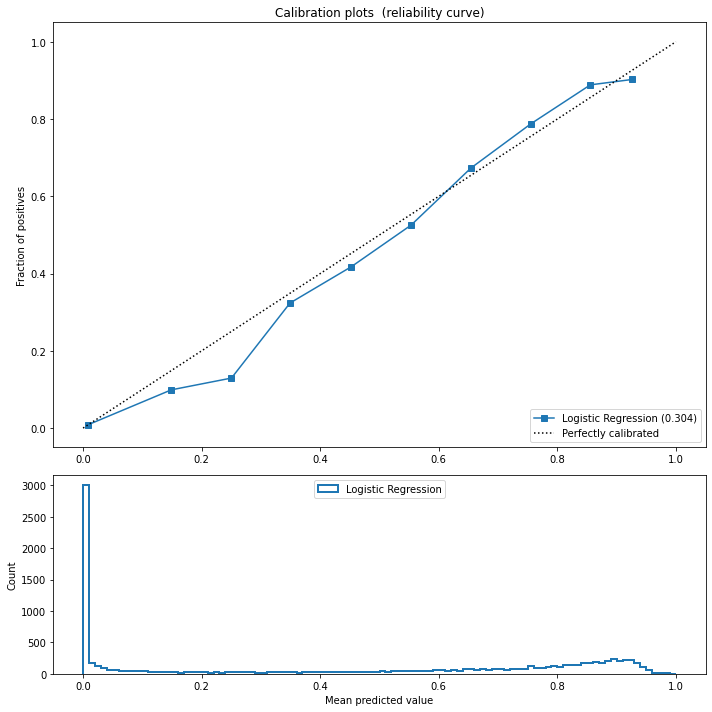

In [14]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

What we see here is a really nice start. The calibration curve follows the diagonal really closely, and the probability outputs are spread nicely across \[0,1\] in the histogram. There is a little bit of pathelogical behaviour towards the 95%+ predicted value, where it seems there are very very few plays that qualify as that high probability. Instead it looks like the non-zero mode is around 90% or a bit higher. The huge spike at 0 is a result of the dataset containing plays that are well out of the SS's range, though not fielded by anyone in the infield so still included. The model can handle this well, though, thanks to the informative features in the input. All in all this is a great curve, with sudden jumps discontinuities in the frequency of any predicted probabilities in the domain.

### Random Forest

In [24]:
%%time

current_model_name = 'Random Forest'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


CPU times: user 33.9 s, sys: 320 ms, total: 34.3 s
Wall time: 35.6 s


Random Forest:  0.026 Brier Score

	Precision: 0.949
	Recall: 0.989
	F1: 0.969
	Log-Loss: 0.107
	Accuracy: 0.973



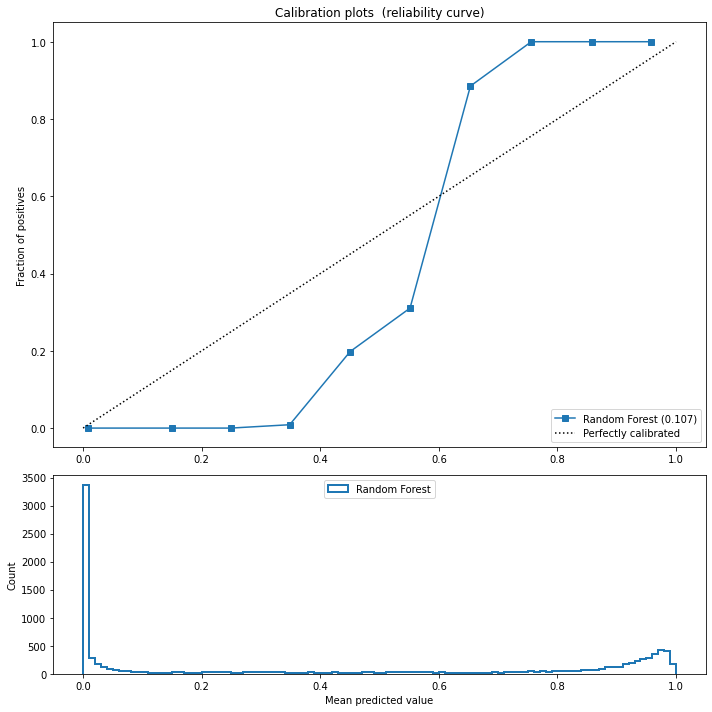

In [25]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

This curve is way different than the previous one, and much worse from a calibration standpoint. The quality of outcome predictions in-sample is very high, as is traditional for random forest models, but that doens't mean much without a robust out-of-sample evaluation (which we're not doing in this notebook). What we really want is a well calibrated probability prediction, and we definitely don't have that here. Predictions with probabilities of up to around 35% have around 0% chance of actually being successful outs, and the inverse is true of predcitions around 75% and up. This would wreck the OAA metric as a player's metric would be entirely at the mercy of what kind of opportunities they got, rather whether they made the most of their opportunities. We want to pass on this model. (note: there are strategies for improving calibration, including training it with the CalibratedClassifierCV class, which I didn't do here). The Brier score I think is misleading here because the accuracy is so high.

### Gaussian Process

In [26]:
%%time

current_model_name = 'Gaussian Process'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


CPU times: user 6min 48s, sys: 52.4 s, total: 7min 41s
Wall time: 6min


Gaussian Process:  0.074 Brier Score

	Precision: 0.863
	Recall: 0.944
	F1: 0.902
	Log-Loss: 0.264
	Accuracy: 0.912



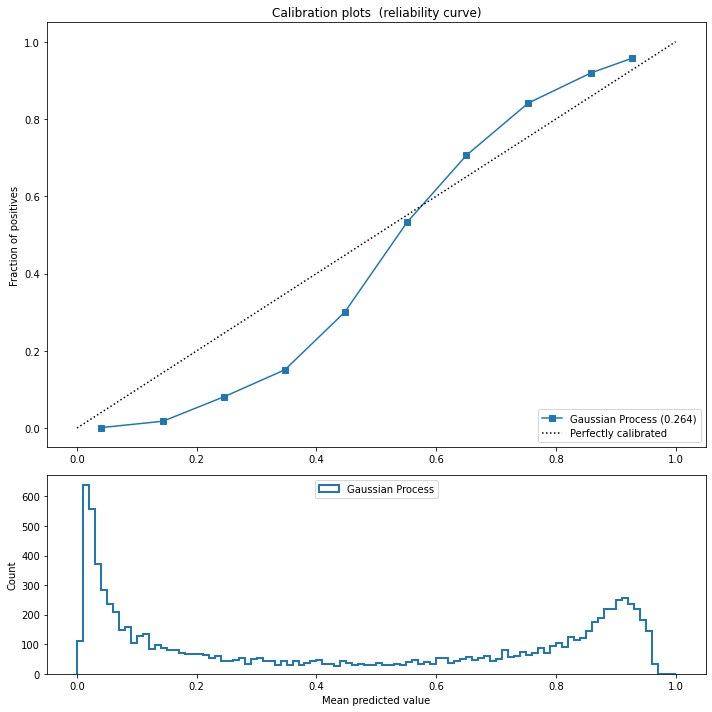

In [27]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

This has a really interesting histogram of probability predictions, since there is such little density at the 0% prediction unlike the other curves. This model outputs predictions with much more density between 20% - 80% than at the extremes. If I didn't know any better I'd think this was a good thing, but knowing the dataset, I know there should be a huge spike around 0% since there are so many balls that are just way out of the SS's range still in the dataset. Perhaps that being the case was a downfall for the Gaussian Process model, and that it would've done better if the dataset was more balanced than it is. The accuracy is impressive despite the smoothness at 0%, and this actually might be a really good candidate for another iteration after working on the dataset filtering.

### SVM-rbf

In [28]:
%%time

current_model_name = 'SVM-RBF v1'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


CPU times: user 22.7 s, sys: 422 ms, total: 23.1 s
Wall time: 24.9 s


SVM-RBF v1:  0.065 Brier Score

	Precision: 0.855
	Recall: 0.954
	F1: 0.902
	Log-Loss: 0.223
	Accuracy: 0.911



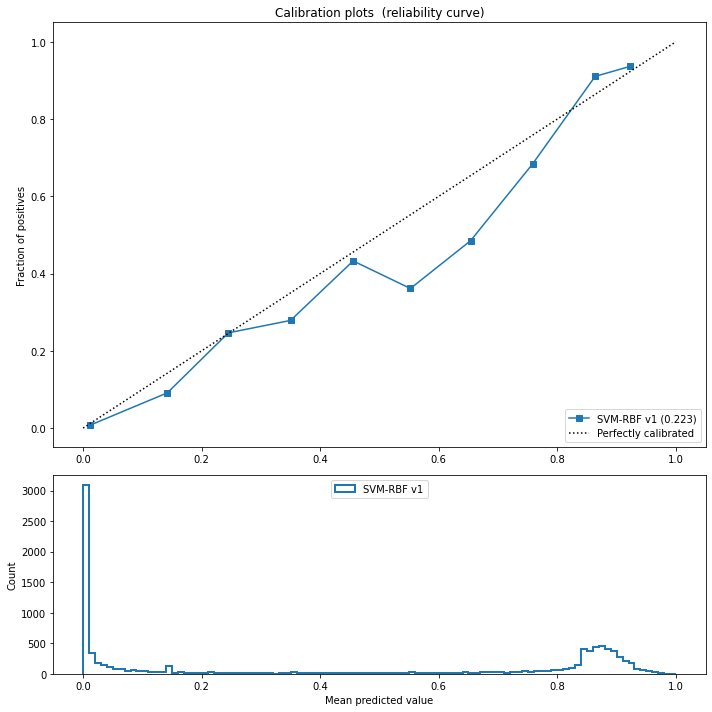

In [29]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

The rbf-kernel SVM is a great all-purpose model since it's max-margin approach (with kernel) makes for a very flexbile algorithm that balances over-fitting and under-fitting well, and it can capture complex non-linear interactions between features. The metrics do show that this was a good model, as the Brier and Log-Likelihood are very good, despite a small kink in the calibration curve (at areas of very low density). Part of why the calibration is good is because the scikit-learn implementation of this algorithm has built-in probability calibration during training. This leads me to believe that if I had used this probability calibration on other models (i.e. Random Forest) I would've gotten better performance from those models too.

This model would be the leader so far if not for two subtle pathologies with the predictions: at around 17% for the SVM (y-axis) there is a spike in frequency, which would indicate a pathology of a disproportionate amount of density being placed on the same exact prediction. There's another similar spike in density on the converse side of the prediction space, at around 83%, also noticable on the histogram. This is something I'd rather avoid. 

### SVM-Poly

In [30]:
%%time

current_model_name = 'SVM-Poly v1'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


CPU times: user 20.4 s, sys: 213 ms, total: 20.6 s
Wall time: 21 s


SVM-Poly v1:  0.074 Brier Score

	Precision: 0.842
	Recall: 0.948
	F1: 0.892
	Log-Loss: 0.254
	Accuracy: 0.901



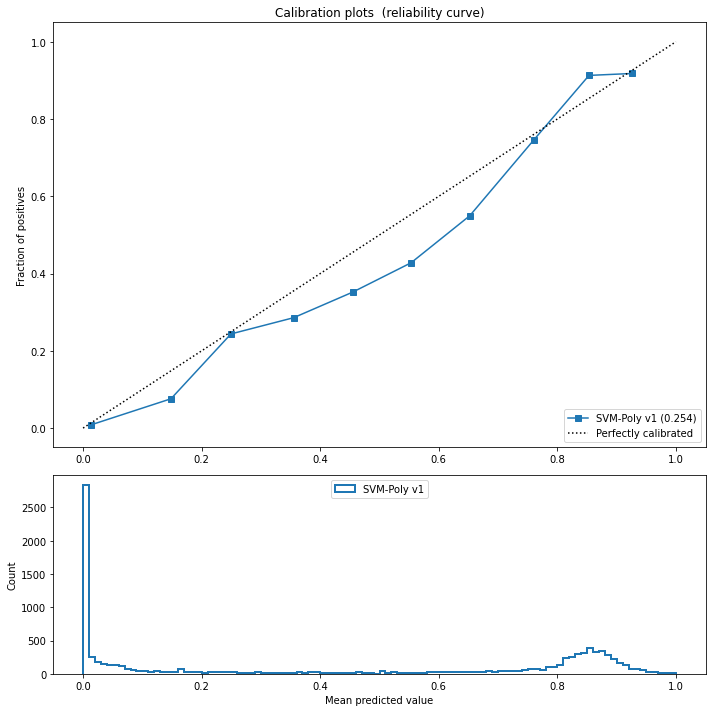

In [31]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

This looks a lot like the rbf-SVM, with maybe a little bit worse calibration (metrics and curve are a little bit worse), though without the bad pathology noticed above. This is the leader so far.

### Gradient Boosted Trees

In [32]:
%%time

current_model_name = 'Gradient Boosted Trees'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)


[22:36:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 5.05 s, sys: 94.1 ms, total: 5.15 s
Wall time: 1.61 s


Gradient Boosted Trees:  0.021 Brier Score

	Precision: 0.952
	Recall: 0.996
	F1: 0.974
	Log-Loss: 0.089
	Accuracy: 0.977



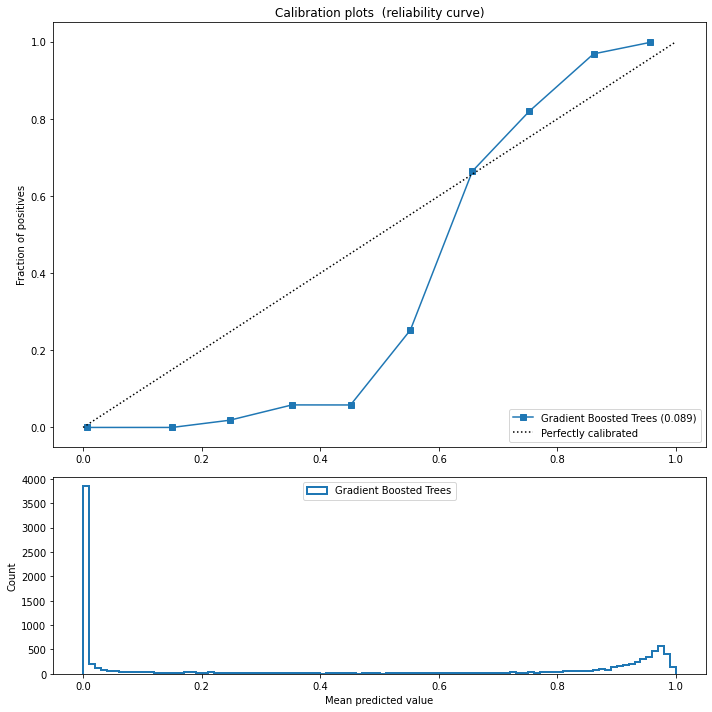

In [33]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

The XGBoost results look a lot like the Random Forest results, it's cousin algorithm. Basically the exact same output here, though the calibration curve is a lot better at high predicted probability. This would potentially be a really great model if I used probability calibration on it.

### GAM v1

In [45]:
%%time

current_model_name = 'GAM v1'

# train model on all data
current_model, preds, preds_proba = train_model(all_models[current_model_name]['model'], X, y)
# clean up the predictions that give probabilities outside of [0, 1], and i'm not sure why that would happen with a logit link...
preds_proba[preds_proba > 1.0] = 1.0
preds_proba[preds_proba < 0.0] = 0.0

/Users/dangoldberg/miniconda3/envs/tbj2021/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


CPU times: user 1.2 s, sys: 178 ms, total: 1.38 s
Wall time: 1.07 s


GAM v1:  0.088 Brier Score

	Precision: 0.807
	Recall: 0.961
	F1: 0.878
	Log-Loss: 0.316
	Accuracy: 0.885



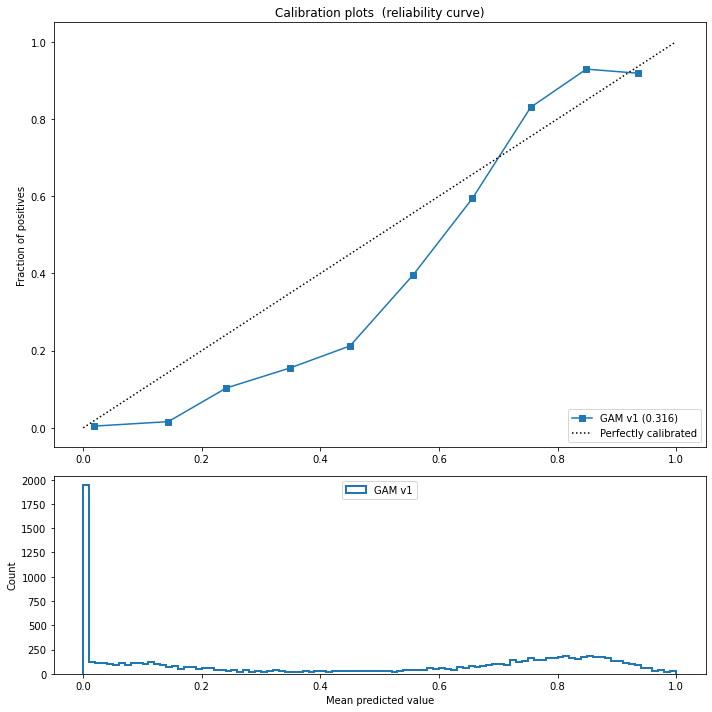

In [46]:
all_models = summarize_model(all_models, current_model_name, y, preds, preds_proba)

The GAM doesn't look great here, with a comparitively high Brier and Log-Loss, with a bad calibration curve. There's almost certainly a lot of room to improve with tweaks to the basis functions, which I didn't experiment with.

### Multilevel Logistic Regression v1

This prediction has to be done manually because the model is a bespoke pyStan model, not a scikit-learn model, and I didn't build a great wrapper for it (yet).

In [63]:
%%time

current_model_name = 'Multilevel Logistic Regression v1'

from scipy.special import expit
from sklearn.preprocessing import OrdinalEncoder

model = all_models[current_model_name]['model']

### preprocessing step

# reindex player id
oe = OrdinalEncoder(dtype=int)
df.loc[:, 'playerid_cat'] = oe.fit_transform(df[['playerid']]) 
levels = df['playerid_cat'].values + 1 # reindex with 1-index
num_levels = np.unique(levels).shape[0]

column_transformer = param_payload['feature_preprocessing']
X_t = column_transformer.fit_transform(X[feature_columns])

# train model on all data
# evaluate model
params = model.params  # return a dictionary of arrays
bias = params['bias'].mean(axis=0)
slope1 = params['slope1'].mean(axis=0)
slope2 = params['slope2'].mean(axis=0)
slope3 = params['slope3'].mean(axis=0)
slope4 = params['slope4'].mean(axis=0)
slope5 = params['slope5'].mean(axis=0)
slope6 = params['slope6'].mean(axis=0)
slope7 = params['slope7'].mean(axis=0)
slope8 = params['slope8'].mean(axis=0)
slope9 = params['slope9'].mean(axis=0)
slope10 = params['slope10'].mean(axis=0)
level_param = params['shortstop_effect'].mean(axis=0)

# get predictions
preds_proba = expit(
    bias \
    + slope1*X_t[:,0] \
    + slope2*X_t[:,1] \
    + slope3*X_t[:,2] \
    + slope4*X_t[:,3] \
    + slope5*X_t[:,4] \
    + slope6*X_t[:,5] \
    + slope7*X_t[:,6] \
    + slope8*X_t[:,7] \
    + slope9*X_t[:,8] \
    + slope10*X_t[:,9] \
    + [level_param[l-1] for l in levels] 
)

preds = (preds_proba > 0.5).astype(int)


CPU times: user 53.4 ms, sys: 63 ms, total: 116 ms
Wall time: 186 ms


Multilevel Logistic Regression v1:  0.092 Brier Score

	Precision: 0.810
	Recall: 0.926
	F1: 0.864
	Log-Loss: 0.303
	Accuracy: 0.875



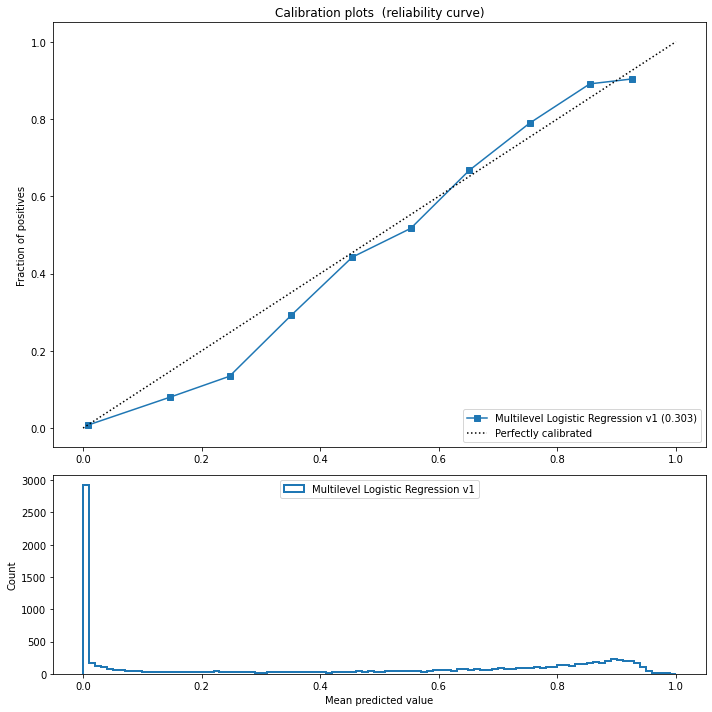

In [64]:
# convert preds_proba into sklearn style 
sk_preds_proba = np.concatenate([ # Stan model only outputs prob of class 1
    1-preds_proba.reshape(-1,1), 
    preds_proba.reshape(-1,1)
], axis=1)

all_models = summarize_model(all_models, current_model_name, y, preds, sk_preds_proba)

This is almost an exact carbon copy of the scikit-learn LogisticRegression model, which is both reassuring (that I made the Stan model correctly), and evidence that the partial pooling of using a variable intercept for each SS didn't do much. Though, the metrics are ever so slightly better than the vanilla Logistic Regression, so this one edges out that model. 

### Decision

I'll go with the SVM-Poly and Multilevel Logistic Regression models as the two finalists, due to the great accuracy, and very good calibraion of the SVM, and the decent accuracy with the excellent calibration curve of the Multilevel Logistic Regression.

# 3 - Compare best two models in more detail

We can look at some summary stats, as well as some spot checks of samples they disagreed on to look for any bad pathology we want to avoid.

In [101]:
%%time

# the multilevel logistic regression variables are already loaded
glmm_model, glmm_preds, glmm_preds_proba = model, preds, preds_proba

# reload the svm variables
svm_model, svm_preds, svm_preds_proba = train_model(all_models['SVM-Poly v1']['model'], X, y)

CPU times: user 23.5 s, sys: 428 ms, total: 23.9 s
Wall time: 25.9 s


### Samples w/ Biggest Dissagreements 

In [102]:
prob_differences = glmm_preds_proba - svm_preds_proba[:, 1]

In [103]:
df.loc[:, 'prob_differences'] = prob_differences

5 Biggest Where GLMM > SVM


/Users/dangoldberg/miniconda3/envs/tbj2021/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/dangoldberg/Desktop/code/interviews/tbj/tbj_202101/src/utils/viz_utils.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(self.coords)
/Users/dangoldberg/Desktop/code/interviews/tbj/tbj_202101/src/utils/viz_utils.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI bac

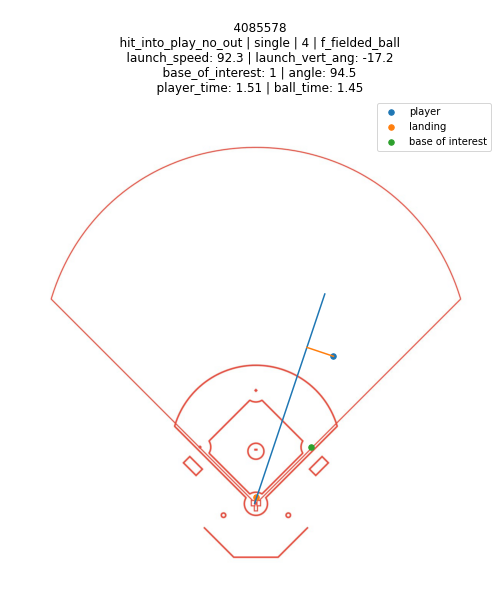

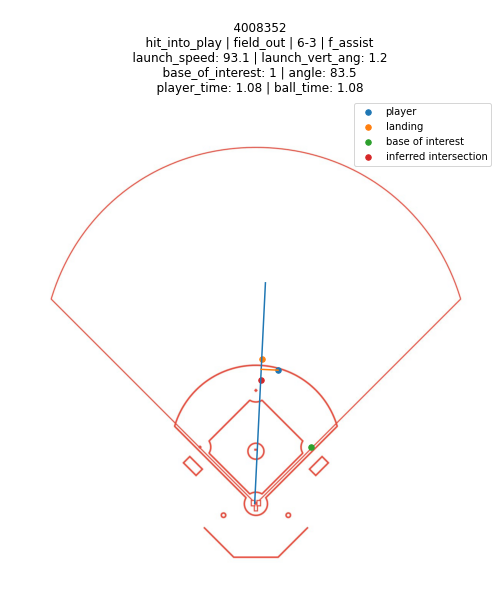

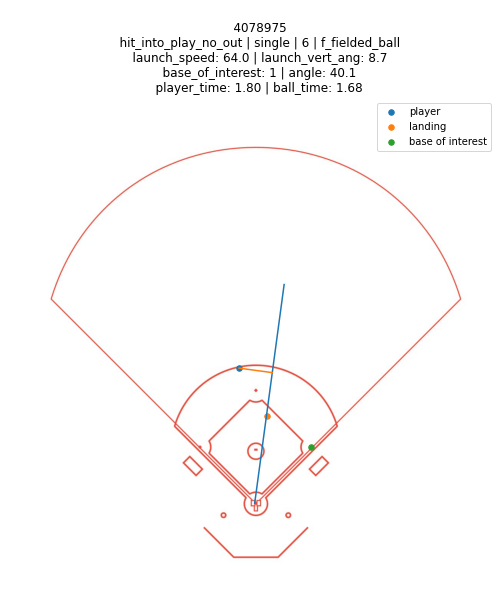

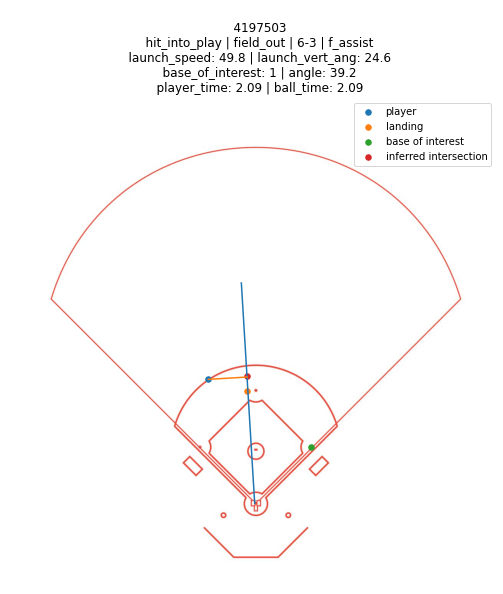

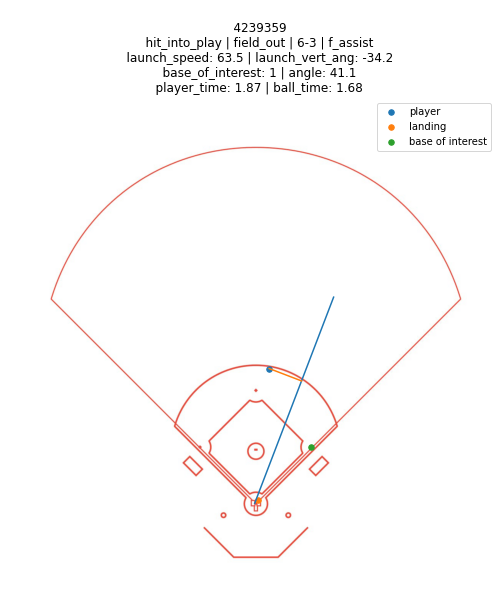

In [104]:
print('5 Biggest Where GLMM > SVM')
for i in range(5):
    plot_single_sample(df.reset_index().sort_values('prob_differences').iloc[[i]])

5 Biggest Where SVM > GLMM


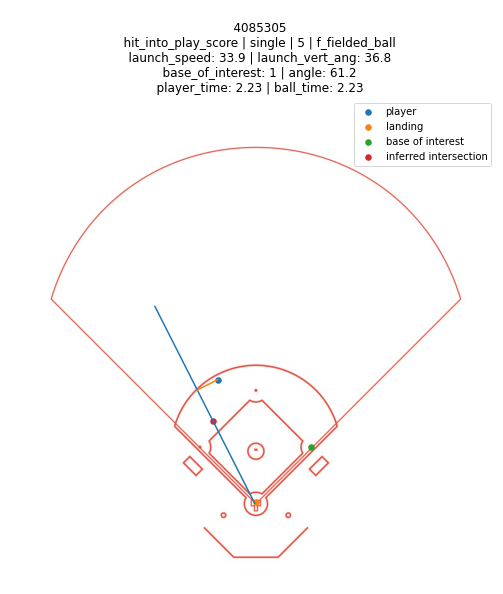

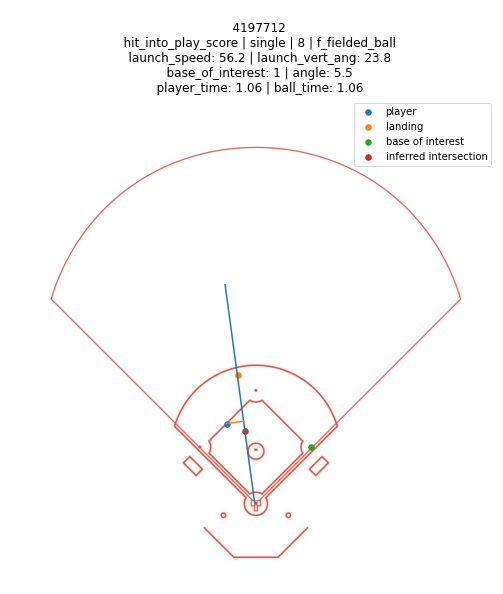

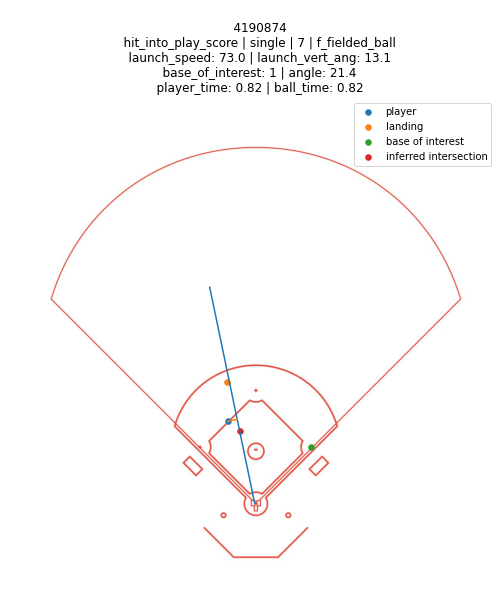

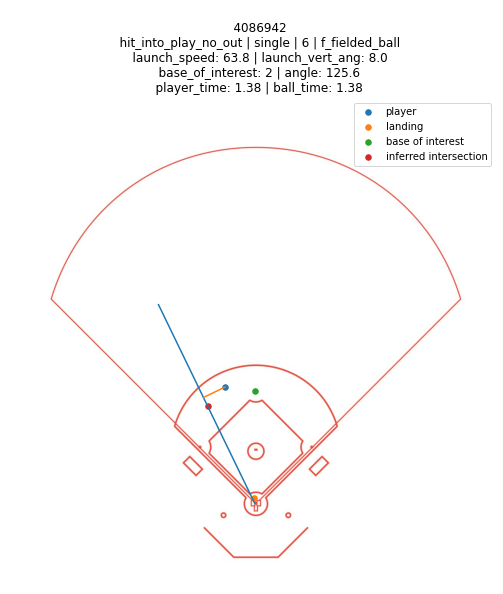

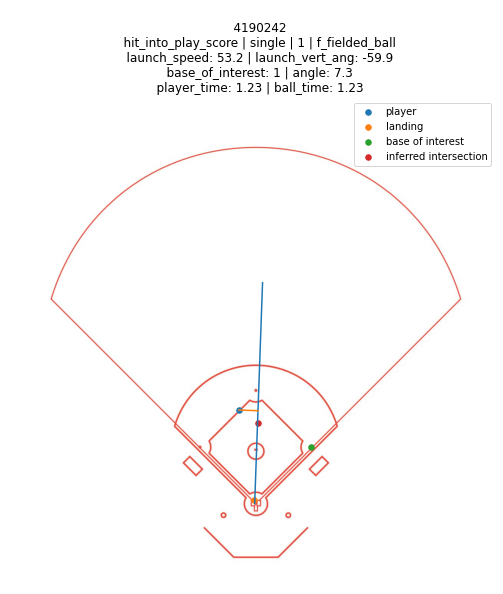

In [85]:
print('5 Biggest Where SVM > GLMM')
for i in range(5):
    plot_single_sample(df.reset_index().sort_values('prob_differences', ascending=False).iloc[[i]])

I honestly can't see any pattern from just inspecting the biggest dissagreements.

### Scatterplot of predictions from both models

[]

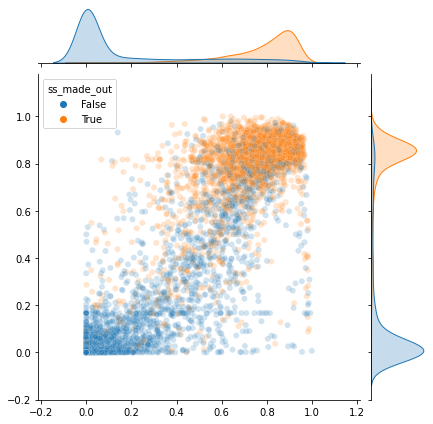

In [105]:
sns.jointplot(x=glmm_preds_proba, y=svm_preds_proba[:, 1], hue=df['ss_made_out'], alpha=0.2)
plt.xlabel('Multilevel Logistic Regression')
plt.ylabel('SVM-Poly')
plt.plot()

The first thing I notice is that at around 17% for the SVM (y-axis) there is a straight line across the x-axis, which would indicate the same pathology of a disproportionate amount of density being placed on the same exact prediction as the SVM-RBF. Looking back up at the histogram of predictions for that model, I can now see that was something I missed above, as it's smaller than the SVM-RBF, but still there. There's another similar spike in density on the converse side of the prediction space, at around 83%, also noticable on the histogram of predictions show in the previous section. For that reason, plus the fact that the fully Bayesian Multilevel Logistic Regression model give me uncertainty estimates, I'll go with the Logistic Regression model. 

# 4 - Generate OAA Leaderboard

Now that we've chosen our model we can use the predicted probabilities to calculate the OAA metric for each player. The Questionnaire also asks to count the number of "opportunities" so I will interpret that to mean the number of reasonable chances for the SS to make the play, and I will output that as well. 

To determine "opportuntities" I'll pick a cut-off in predicted probability that is very very low, so that in theory making the play was extremely unlikely but not impossible. For this I'll choose 0.5%, so that the play is made in 1/200 opportunities.

#### First I'll use the fully bayesian output instead of just the mean parameter estimates

In [161]:


params = model.params  # return a dictionary of arrays
bias = params['bias']
slope1 = params['slope1']
slope2 = params['slope2']
slope3 = params['slope3']
slope4 = params['slope4']
slope5 = params['slope5']
slope6 = params['slope6']
slope7 = params['slope7']
slope8 = params['slope8']
slope9 = params['slope9']
slope10 = params['slope10']
level_param = params['shortstop_effect']

# get predictions
preds_proba = expit(
    bias.reshape(-1,1) \
    + slope1.reshape(-1,1)*X_t[:,0].reshape(1,-1) \
    + slope2.reshape(-1,1)*X_t[:,1].reshape(1,-1) \
    + slope3.reshape(-1,1)*X_t[:,2].reshape(1,-1) \
    + slope4.reshape(-1,1)*X_t[:,3].reshape(1,-1) \
    + slope5.reshape(-1,1)*X_t[:,4].reshape(1,-1) \
    + slope6.reshape(-1,1)*X_t[:,5].reshape(1,-1) \
    + slope7.reshape(-1,1)*X_t[:,6].reshape(1,-1) \
    + slope8.reshape(-1,1)*X_t[:,7].reshape(1,-1) \
    + slope9.reshape(-1,1)*X_t[:,8].reshape(1,-1) \
    + slope10.reshape(-1,1)*X_t[:,9].reshape(1,-1) \
    + np.stack([level_param[:, l-1] for l in levels]).T
)

#### Then i'll combine that data in an xarray Dataset

I have to use an xarray Dataset so that I can pass in the (samples, observations) 2D array as data for ss_out_probability,
OAA, and opportunities columns so I can first groupby playerid and aggregate across observations, and only at the end take the mean and std across samples.

In [207]:
import xarray as xr 

def summarize_outs_above_average(df, y, preds_proba, min_prob_for_opportunity = 0.005):
    """
    This function prepares a dataframe that summarizes the OAA metric, given a model's probability predictions.
    """

    model_output = xr.Dataset({
        'ss_out_probability':(['samples','observations'], preds_proba),
        'OAA': (['samples','observations'], y.values-preds_proba),
        'opportunities': (['samples', 'observations'], (preds_proba > min_prob_for_opportunity).astype(int)), # over a 0.5% chance
        'observed_out': ('observations', y),
        'playerid': ('observations', df['playerid'].values)
    })
    
    return model_output

In [221]:
oaa = summarize_outs_above_average(df, y, preds_proba)
oaa

<xarray.Dataset>
Dimensions:             (observations: 9362, samples: 2000)
Dimensions without coordinates: observations, samples
Data variables:
    ss_out_probability  (samples, observations) float64 0.9111 0.7825 ... 0.174
    OAA                 (samples, observations) float64 0.08889 ... -0.174
    opportunities       (samples, observations) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    observed_out        (observations) int64 1 0 1 1 1 0 0 1 ... 0 1 0 1 0 1 0 0
    playerid            (observations) int64 11742 9425 5419 ... 161551 208314

In [239]:
# aggregate across observations to get player-level stats
player_summary = oaa.groupby('playerid')\
                    .sum(dim='observations')

# aggregate across samples to get bayesian flavour of metrics
player_summary['OAA_mean'] = player_summary.OAA.mean(dim='samples')
player_summary['OAA_std'] = player_summary.OAA.std(dim='samples')
player_summary['opportunities'] = player_summary.opportunities.mean(dim='samples')

# convert to pandas dataframe
player_summary = player_summary[['opportunities','OAA_mean','OAA_std']].to_dataframe().sort_values('OAA_mean', ascending=False)
player_summary['OAA_per_Opp'] = player_summary['OAA_mean'] / player_summary['opportunities']

player_summary

,opportunities,OAA_mean,OAA_std,OAA_per_Opp
playerid,,,,
162066,227.94,11.09,4.83,0.05
162648,196.57,9.15,4.04,0.05
197513,90.34,4.46,1.91,0.05
154448,225.88,4.34,3.78,0.02
9742,97.64,4.22,1.80,0.04
...,...,...,...,...
160570,182.68,-4.08,3.27,-0.02
164881,117.42,-4.11,2.32,-0.03
6619,57.08,-4.80,1.40,-0.08


In [240]:
# prep leaderboard with rank
player_summary = player_summary.reset_index().reset_index().rename(columns={'index':'rank'})
player_summary.loc[:, 'rank'] = player_summary['rank'] + 1
player_summary = player_summary.set_index('rank')

In [241]:
format_1d = "{0:.1f}".format
format_2d = "{0:.2f}".format
format_3d =  "{0:.3f}".format

player_summary[['opportunities']] = player_summary[['opportunities']].applymap(format_1d)
player_summary[['OAA_mean','OAA_std']] = player_summary[['OAA_mean','OAA_std']].applymap(format_2d)
player_summary[['OAA_per_Opp']] = player_summary[['OAA_per_Opp']].applymap(format_3d)

player_summary[:20] # top 20

,playerid,opportunities,OAA_mean,OAA_std,OAA_per_Opp
rank,,,,,
1,162066,227.9,11.09,4.83,0.049
2,162648,196.6,9.15,4.04,0.047
3,197513,90.3,4.46,1.91,0.049
4,154448,225.9,4.34,3.78,0.019
5,9742,97.6,4.22,1.80,0.043
6,2950,151.2,4.11,2.73,0.027
7,168314,178.1,4.07,3.10,0.023
8,5495,226.8,3.98,3.78,0.018
9,9148,155.7,2.88,2.65,0.018


In [282]:
player_summary.to_csv('../data/ss_OAA.csv')

In [245]:
# for markdown doc

print(player_summary[:20].to_markdown())

|   rank |   playerid |   opportunities |   OAA_mean |   OAA_std |   OAA_per_Opp |
|-------:|-----------:|----------------:|-----------:|----------:|--------------:|
|      1 |     162066 |           227.9 |      11.09 |      4.83 |         0.049 |
|      2 |     162648 |           196.6 |       9.15 |      4.04 |         0.047 |
|      3 |     197513 |            90.3 |       4.46 |      1.91 |         0.049 |
|      4 |     154448 |           225.9 |       4.34 |      3.78 |         0.019 |
|      5 |       9742 |            97.6 |       4.22 |      1.8  |         0.043 |
|      6 |       2950 |           151.2 |       4.11 |      2.73 |         0.027 |
|      7 |     168314 |           178.1 |       4.07 |      3.1  |         0.023 |
|      8 |       5495 |           226.8 |       3.98 |      3.78 |         0.018 |
|      9 |       9148 |           155.7 |       2.88 |      2.65 |         0.018 |
|     10 |       9074 |           181   |       2.81 |      3.19 |         0.016 |
|   

### For kicks let's compare to the player-level variable intercept in the heirarchical model

In [277]:
ss_effect_intercept_mean = level_param.mean(axis=0)
ss_effect_intercept_std = level_param.std(axis=0)

In [278]:
encoded_levels = np.array(range(len(ss_effect_intercept_mean)))
ss_effect_playerids = oe.inverse_transform(encoded_levels.reshape(-1,1)).reshape(-1)

In [283]:
glmm_results = pd.DataFrame({
    'playerid':ss_effect_playerids,
    'ss_effect_intercept_mean': ss_effect_intercept_mean,
    'ss_effect_intercept_std': ss_effect_intercept_std
}).sort_values('ss_effect_intercept_mean', ascending=False)

glmm_results[:20]

,playerid,ss_effect_intercept_mean,ss_effect_intercept_std
56,162066,0.21,0.15
59,162648,0.18,0.15
87,197513,0.09,0.14
32,9742,0.09,0.13
4,2950,0.09,0.13
46,154448,0.08,0.12
14,5495,0.08,0.12
70,168314,0.08,0.12
57,162294,0.06,0.15
26,9148,0.06,0.12


Close, but they order is slightly different! My guess is the difference is that the variable intercept captures the 'skill' of the player to add incremental probabilty of making an out independant of the kinds of opportunities they actually saw. In contrast, the observed difference of making an out vs the probability of making an out (OAA metric) is sensitive to the opportunities a player actually gets, in addition to their skill.

In [284]:
glmm_results.to_csv('../data/ss_defense_glmm.csv', index=False)

### Thanks! I enjoyed this :)